In [1679]:
"""
Quantum Addition Circuit
Kvantový sčítačový obvod

This program simulates a quantum circuit for binary addition using the quantum Fourier transform using Qiskit.

Author: Michal Forgó

Time: 02.12.2025

Note: Ensure you have installed the requirements.txt or environment.yml before running this notebook.
Poznámka: Před spuštěním tohoto notebooku se ujistěte, že máte nainstalované requiremnts.txt nebo enviroment.yml.
"""

'\nQuantum Addition Circuit\nKvantový sčítačový obvod\n\nThis program simulates a quantum circuit for binary addition using the quantum Fourier transform using Qiskit.\n\nAuthor: Michal Forgó\n\nTime: 02.12.2025\n\nNote: Ensure you have installed the requirements.txt or environment.yml before running this notebook.\nPoznámka: Před spuštěním tohoto notebooku se ujistěte, že máte nainstalované requiremnts.txt nebo enviroment.yml.\n'

In [1680]:
import math
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, DraperQFTAdder



In [1681]:
while True:
    # Get two binary numbers (max 7 bits)
    # Získejte dvě binární čísla (max 7 bitů)
    firstBinaryNumber = input("Enter a 7-bit or less binary number: ")
    secondBinaryNumber = input("Enter another 7-bit or less binary number: ")

    # Validate input length and that input contains only 1s or 0s
    # Ověření délky vstupu a toho že vstup obsahuje pouze 1 nebo 0
    if len(firstBinaryNumber) > 8 or len(secondBinaryNumber) > 8 or \
    not set(firstBinaryNumber).issubset({'0','1'}) or not set(secondBinaryNumber).issubset({'0','1'}):
        print("Please enter valid inputs. Try again.")  # Error message / Chybová zpráva
    else:
        break  # Exit loop if input is valid / Ukončí smyčku, pokud je vstup platný
# Binary numbers to add
#firstBinaryNumber = "1010"  
#secondBinaryNumber = "1010" 

# Ensure both numbers have the same length
if len(firstBinaryNumber) < len(secondBinaryNumber):
    firstBinaryNumber, secondBinaryNumber = secondBinaryNumber, firstBinaryNumber

secondBinaryNumber = "0" * (len(firstBinaryNumber) - len(secondBinaryNumber)) + secondBinaryNumber
maxInputLength = len(firstBinaryNumber)
m = maxInputLength + 1

In [1682]:

# Quantum registers
regA = QuantumRegister(maxInputLength+1, "regA")
regB = QuantumRegister(maxInputLength+1, "regB")
regC = ClassicalRegister(maxInputLength + 1, "regC")
qc = QuantumCircuit(regA, regB, regC, name="qc")


In [1683]:

# Initialize qubits
for idx, val in enumerate(firstBinaryNumber):
    if val == "1":
        qc.x(regA[maxInputLength - (idx + 1)])
for idx, val in enumerate(secondBinaryNumber):
    if val == "1":
        qc.x(regB[maxInputLength - (idx + 1)])


In [ ]:
for target in range(maxInputLength, -1, -1):
    qc.h(regB[target])
    for control in range(target-1, -1, -1):
        print(target, control)
        qc.cp(math.pi*(2**(control-target)), regB[target], regB[control])
qc.barrier()

for target in range(maxInputLength):
    for control in range(maxInputLength + 1 - target):
        print(target, control)
        lam = math.pi / (2**control)
        qc.cp(lam, regA[target], regB[target+control])
qc.barrier()
"""
for target in range(maxInputLength + 1):
    qc.h(regB[target])
    for control in range(target+1, maxInputLength + 1):
        qc.cp(-math.pi/(2**(control-target)), regB[control], regB[target])
qc.barrier()
# Decomposed to qfts
qc.append(QFT(maxInputLength + 1, do_swaps=False, name="qft").to_gate(), regB[:])
qc.barrier()

for j in range(maxInputLength):
    for k in range(maxInputLength + 1 - j):
         lam = math.pi / (2**k)
         qc.cp(lam, regA[j], regB[j+k])
qc.barrier()

qc.append(QFT(maxInputLength + 1, do_swaps=False, name="iqft").inverse().to_gate(), regB[:])
qc.barrier()
"""
# Prepared gate
#qc.append(DraperQFTAdder(maxInputLength+1), qargs=regA[:] + regB[:])


6 5
6 4
6 3
6 2
6 1
6 0
5 4
5 3
5 2
5 1
5 0
4 3
4 2
4 1
4 0
3 2
3 1
3 0
2 1
2 0
1 0
0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
4 0
4 1
4 2
5 0
5 1


'\n# Decomposed to qfts\nqc.append(QFT(maxInputLength + 1, do_swaps=False, name="qft").to_gate(), regB[:])\nqc.barrier()\n\nfor j in range(maxInputLength):\n    for k in range(maxInputLength + 1 - j):\n         lam = math.pi / (2**k)\n         qc.cp(lam, regA[j], regB[j+k])\nqc.barrier()\n\nqc.append(QFT(maxInputLength + 1, do_swaps=False, name="iqft").inverse().to_gate(), regB[:])\nqc.barrier()\n'

0101100


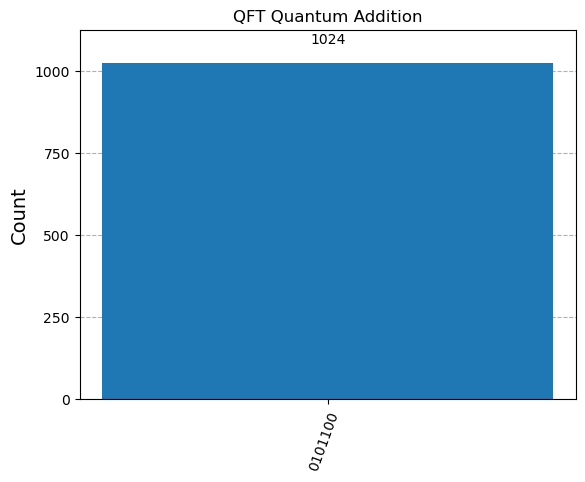

In [1685]:

# Measure qubits
qc.measure(regB, regC)
# Transpile and simulate the circuit
simulator = AerSimulator()
circ = transpile(qc, simulator)
result = simulator.run(circ).result()
counts = result.get_counts(circ)

# Extract and print the most probable output

print(max(counts, key=counts.get))
# Draw circuit and plot histogram
#qc.decompose(gates_to_decompose=["qft","iqft"]).draw("mpl")
plot_histogram(counts, title='QFT Quantum Addition')